PAPER - AN IMAGE IS WORTH 16X16 WORDS : TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE - [PDF](https://arxiv.org/pdf/2010.11929.pdf)

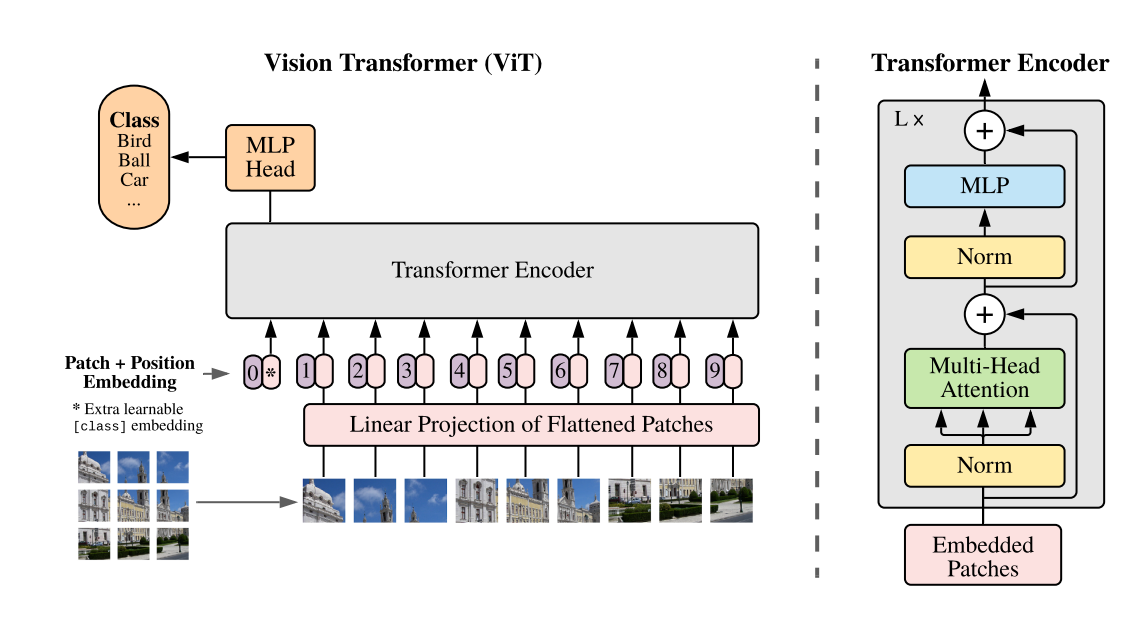

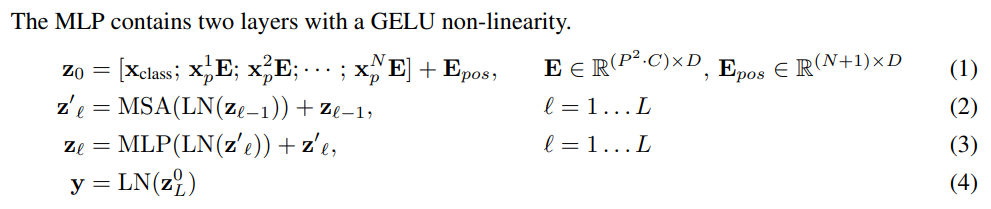

# 결론 및 시사

* NLP에 사용되는 standard Transformer를 이미지에 사용하여 이미지 분류과제를 수행
* ViT는 이미지를 Patch로 분할하고 이를 NLP의 단어처럼 취급하여 각 패치의 Linear embedding 순서대로 input에 넣음
* 적은 데이터(ImageNet-1K)에서 Resnet보다 낮은 정확도를 도출하는 것을 알수있고 CNN, RNN 보다 상대적으로 Inductive bias 가 낮다는 것을 알 수 있음
* 하지만 JFT-300M와 같은 대용량의 데이터에서 pre-training한 ViT를 Transfer-learning 했을때 ViT가 SOTA에 도달하는 것을 보면 large-scale의 학습이 낮은 inductive bias를 해소시키는 것을 유추할 수 있음

# 준비

## 라이브러리 호출

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa

import matplotlib.pyplot as plt

## 데이터 준비

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## 하이퍼 파라미터 지정

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 100
num_epochs = 100
image_size = 72  # 이미지 사이즈 32에서 72로 늘림
patch_size = 6  # 패치 한개의 사이즈
num_patches = (image_size // patch_size) ** 2 # 패치의 개수
projection_dim = 64 # 임베딩 차원수
num_heads = 4 # MHA의 head 수
transformer_units = [projection_dim * 2,projection_dim]  # 레이어의 사이즈
transformer_layers = 8 # 레이어 갯수
mlp_head_units = [2048, 1024]  # 마지막 Dense 층 레이어

## 증강

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(), #정규화
        layers.Resizing(image_size, image_size), # 사이즈 조절
        layers.RandomFlip("horizontal"), # 수평 뒤집기
        layers.RandomRotation(factor=0.02), # 회전
        layers.RandomZoom(height_factor=0.2, width_factor=0.2) # 확대
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)

# 모델링

## MLP 층

In [5]:
# input = x
# output = x
# MLP 적용 레이어
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## 이미지를 패치로 나누는 층

In [6]:
class Patches(layers.Layer): # 레이어 클래스를 상속
    def __init__(self, patch_size): 
        super(Patches, self).__init__()
        self.patch_size = patch_size # 패치사이즈

    def call(self, images): # 함수가 사용되면
        batch_size = tf.shape(images)[0] # 배치 개수
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1], # 패치의 형태
            strides=[1, self.patch_size, self.patch_size, 1], # 패치 strides
            rates=[1, 1, 1, 1], # [1, rate_rows, rate_cols, 1],  Atrous 와 같음
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### sample_process

In [7]:
sample_img =x_train[0]
print(sample_img.shape)
sample_img = tf.expand_dims(sample_img, 0)
print(sample_img.shape)

(32, 32, 3)
(1, 32, 32, 3)


In [8]:
sample_pathes = tf.image.extract_patches(
    images = sample_img,
    sizes=[1, 6, 6, 1],
    strides=[1,6,6,1],
    rates=[1,1,1,1],
    padding="VALID")
sample_pathes.shape # 길이가 32->5 로 6배 작아지고, 채널수가 3에서 108로 36배 커졌다
# 실제로는 32->72로 늘린다음 6으로 자르기 때문에 길이는 12배작아지고, 채널수는 144배 커진다.

TensorShape([1, 5, 5, 108])

### sample_image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


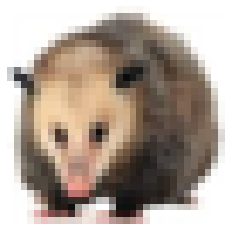

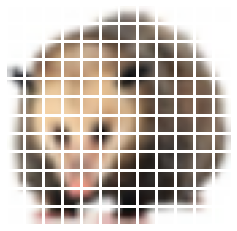

In [9]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}") # 이미지의 사이즈(늘린 후)
print(f"Patch size: {patch_size} X {patch_size}") # 패치 1개의 사이즈
print(f"Patches per image: {patches.shape[1]}") # 총 패치 개수
print(f"Elements per patch: {patches.shape[-1]}") # 길이 * 길이 * 3

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## 패치 인코딩층

In [10]:
class PatchEncoder(layers.Layer): # 레이어 객체 상속
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches # 패치의 개수
        self.projection = layers.Dense(units=projection_dim) # 임베딩 차원수
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
        # input_dim = 패치 개수
        # output_dim = 임베딩 차원수
        # 모든 input 데이터를 받음

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1) # start:0 에서 패치개수 미만까지 공차 1 -> 0,1,2,,,143
        encoded = self.projection(patch) + self.position_embedding(positions) # 각 패치가 각 embedding position에 위치하도록
        return encoded

## Vision Transformer
* layers.MultiHeadAttention 로 이루어진 여러개의 Transformer blocks 으로 이루어짐

In [12]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape) # input
    augmented = data_augmentation(inputs) # 전처리 및 증강
    patches = Patches(patch_size)(augmented) # 패치
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) # 임베딩

    for _ in range(transformer_layers): # 각 레이어에
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches) # 레이어 정규화     
        
        # MHA 생성 ( head 개수, 임베딩 차원수, dropout 비율), (x1, x1)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1) 
        x2 = layers.Add()([attention_output, encoded_patches]) # skip_connection
        
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2) # 레이어 정규화
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1) # MLP
        encoded_patches = layers.Add()([x3, x2]) # skip_connection

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches) # 레이어 정규화
    representation = layers.Flatten()(representation) # Flatten
    representation = layers.Dropout(0.5)(representation) #dropout
    
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5) # MLP, mlp_head_units = [2048, 1024] 
    logits = layers.Dense(num_classes)(features)  # Classify outputs.
    model = keras.Model(inputs=inputs, outputs=logits) # create model
    return model

In [13]:
vit_classifier = create_vit_classifier()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches_1[0][0]']              
                                                                                              

 multi_head_attention_3 (MultiH  (None, 144, 64)     66368       ['layer_normalization_6[0][0]',  
 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                                  
 add_6 (Add)                    (None, 144, 64)      0           ['multi_head_attention_3[0][0]', 
                                                                  'add_5[0][0]']                  
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 144, 64)     128         ['add_6[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_7 (Dense)                (None, 144, 128)     8320        ['layer_normalization_7[0][0]']  
          

                                                                                                  
 dropout_13 (Dropout)           (None, 144, 64)      0           ['dense_14[0][0]']               
                                                                                                  
 add_13 (Add)                   (None, 144, 64)      0           ['dropout_13[0][0]',             
                                                                  'add_12[0][0]']                 
                                                                                                  
 layer_normalization_14 (LayerN  (None, 144, 64)     128         ['add_13[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 144, 64)     66368       ['layer_normalization_14[0][0]', 
 eadAttent

# 컴파일 및 훈련, 평가

In [15]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay) 
    #learning_rate = 0.001,weight_decay = 0.0001
    
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./model/ViT.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

history = run_experiment(vit_classifier)

Epoch 1/100
450/450 [==============================] - 78s 162ms/step - loss: 4.0600 - accuracy: 0.0756 - top-5-accuracy: 0.2524 - val_loss: 3.7262 - val_accuracy: 0.1158 - val_top-5-accuracy: 0.3604
Epoch 2/100
450/450 [==============================] - 73s 163ms/step - loss: 3.8678 - accuracy: 0.1002 - top-5-accuracy: 0.3121 - val_loss: 3.6098 - val_accuracy: 0.1464 - val_top-5-accuracy: 0.3882
Epoch 3/100
450/450 [==============================] - 73s 163ms/step - loss: 3.7200 - accuracy: 0.1255 - top-5-accuracy: 0.3580 - val_loss: 3.5151 - val_accuracy: 0.1652 - val_top-5-accuracy: 0.4252
Epoch 4/100
450/450 [==============================] - 73s 163ms/step - loss: 3.6513 - accuracy: 0.1356 - top-5-accuracy: 0.3808 - val_loss: 3.4508 - val_accuracy: 0.1804 - val_top-5-accuracy: 0.4466
Epoch 5/100
450/450 [==============================] - 73s 163ms/step - loss: 3.5100 - accuracy: 0.1613 - top-5-accuracy: 0.4195 - val_loss: 3.2023 - val_accuracy: 0.2226 - val_top-5-accuracy: 0.4996


Epoch 42/100
450/450 [==============================] - 73s 163ms/step - loss: 1.8020 - accuracy: 0.5060 - top-5-accuracy: 0.8133 - val_loss: 2.1966 - val_accuracy: 0.4332 - val_top-5-accuracy: 0.7288
Epoch 43/100
450/450 [==============================] - 74s 164ms/step - loss: 1.7948 - accuracy: 0.5096 - top-5-accuracy: 0.8161 - val_loss: 2.2072 - val_accuracy: 0.4340 - val_top-5-accuracy: 0.7340
Epoch 44/100
450/450 [==============================] - 74s 164ms/step - loss: 1.7695 - accuracy: 0.5141 - top-5-accuracy: 0.8202 - val_loss: 2.1754 - val_accuracy: 0.4452 - val_top-5-accuracy: 0.7332
Epoch 45/100
450/450 [==============================] - 80s 177ms/step - loss: 1.7542 - accuracy: 0.5187 - top-5-accuracy: 0.8236 - val_loss: 2.2036 - val_accuracy: 0.4468 - val_top-5-accuracy: 0.7350
Epoch 46/100
450/450 [==============================] - 74s 164ms/step - loss: 1.7398 - accuracy: 0.5238 - top-5-accuracy: 0.8262 - val_loss: 2.1726 - val_accuracy: 0.4546 - val_top-5-accuracy: 0.

Epoch 83/100
450/450 [==============================] - 72s 160ms/step - loss: 1.3651 - accuracy: 0.6150 - top-5-accuracy: 0.8879 - val_loss: 2.0650 - val_accuracy: 0.4818 - val_top-5-accuracy: 0.7680
Epoch 84/100
450/450 [==============================] - 72s 160ms/step - loss: 1.3551 - accuracy: 0.6143 - top-5-accuracy: 0.8894 - val_loss: 2.0353 - val_accuracy: 0.4848 - val_top-5-accuracy: 0.7676
Epoch 85/100
450/450 [==============================] - 72s 160ms/step - loss: 1.3652 - accuracy: 0.6120 - top-5-accuracy: 0.8891 - val_loss: 2.0632 - val_accuracy: 0.4842 - val_top-5-accuracy: 0.7612
Epoch 86/100
450/450 [==============================] - 72s 160ms/step - loss: 1.3367 - accuracy: 0.6231 - top-5-accuracy: 0.8933 - val_loss: 2.0801 - val_accuracy: 0.4878 - val_top-5-accuracy: 0.7628
Epoch 87/100
450/450 [==============================] - 72s 160ms/step - loss: 1.3486 - accuracy: 0.6173 - top-5-accuracy: 0.8913 - val_loss: 2.0782 - val_accuracy: 0.4798 - val_top-5-accuracy: 0.

# 결과

* 다른 기존의 CNN 모델에 비해 좋은 점수가 나오지는 않았다.
* JMP dataset 으로 pretrained 된 모델을 가져오거나 더 높은 epochs를 가져야한다.
* 하지만 CNN 모델의 수렴속도에 비해 월등히 느린 속도를 보인다.

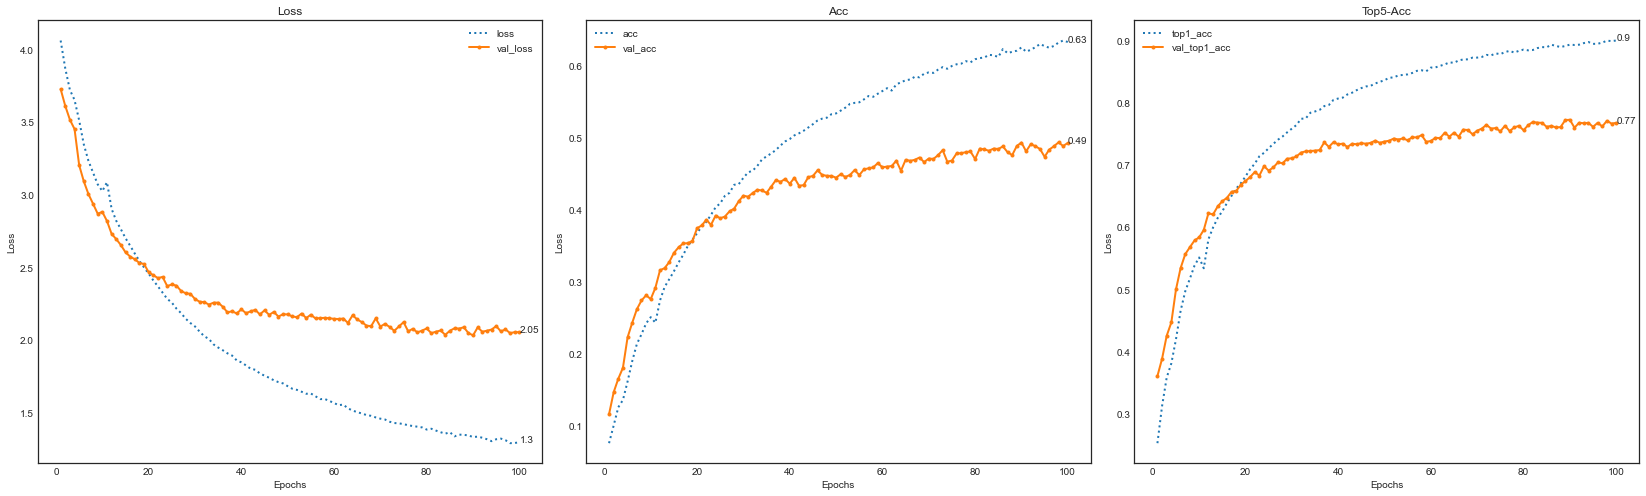

In [46]:
plt.figure(figsize=(23,7))
plt.style.use("seaborn-white")
# loss 
plt.subplot(131)
epochs = range(1, 1+len(loss))
xbins = range(0, len(loss)+1, 10)
plt.plot(epochs, loss, lw=2,linestyle=':', label="loss")
plt.plot(epochs, val_loss, lw=2,marker='.', label="val_loss")
plt.xlabel('Epochs');plt.ylabel('Loss')
x, y = epochs[-1], loss[-1]
plt.text(x, y, np.round(y,2))
x, y = epochs[-1], val_loss[-1]
plt.text(x, y, np.round(y,2))
plt.legend()
plt.title("Loss")

plt.subplot(132)
plt.plot(epochs, acc, lw=2,linestyle=':', label="acc")
plt.plot(epochs, val_acc, lw=2,marker='.', label="val_acc")
plt.xlabel('Epochs');plt.ylabel('Loss')
x, y = epochs[-1], acc[-1]
plt.text(x, y, np.round(y,2))
x, y = epochs[-1], val_acc[-1]
plt.text(x, y, np.round(y,2))
plt.legend()
plt.title("Acc")

plt.subplot(133)
plt.plot(epochs, top1_acc, lw=2,linestyle=':',label="top1_acc")
plt.plot(epochs, val_top1_acc, lw=2,marker='.', label="val_top1_acc")
plt.xlabel('Epochs');plt.ylabel('Loss')
x, y = epochs[-1], top1_acc[-1]
plt.text(x, y, np.round(y,2))
x, y = epochs[-1], val_top1_acc[-1]
plt.text(x, y, np.round(y,2))
plt.legend()
plt.title("Top5-Acc")

plt.tight_layout()
plt.show()

In [38]:
from Myfunc import show_lcurve

loss = history.history["loss"]
val_loss = history.history["val_loss"]

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

top1_acc = history.history["top-5-accuracy"]
val_top1_acc = history.history["val_top-5-accuracy"]